# Linear and Logistic Regression with Keras

## Setup

In [1]:
# Note: a "dependency resolver" error may occur here; ignore it.
!pip list | egrep 'keras|tensorflow |torch '
!pip install -U keras

keras                                    2.15.0
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.4.6
tensorflow                               2.15.0
torch                                    2.1.2+cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.0 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.


In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
print("Keras", keras.__version__, 'on', keras.backend.backend())
assert keras.__version__.startswith('3'), "Somehow got Keras 2; try stopping and restarting the session"
import numpy as np
np.set_printoptions(precision=3)
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

def show_weight_images(linear_layer):
    weights, bias = linear_layer.get_weights()
    weight_images = weights.T.reshape(-1, 28, 28)
    if weight_images.shape[0] == 10:
        nrow, ncol = 2, 5
    else:
        nrow, ncol = 1, 1
    with matplotlib.rc_context(rc={'image.cmap': 'RdBu'}):
        vmax = np.abs(weight_images).max()
        fig, axs = plt.subplots(nrow, ncol, squeeze=False)
        for i, ax in enumerate(axs.flatten()):
            ax.imshow(weight_images[i], vmax=vmax, vmin=-vmax)
            ax.set(title=f'{i}')
            ax.axis('off')

Keras 3.0.4 on torch


# Data Loading

In [3]:
from keras.datasets import mnist

DATASET = 'mnist'

if DATASET == 'toy':
    x = np.array([0, 1, 2, 3])[:, np.newaxis]
    y_true = np.array([-1, .5, 2.0, 3.5])[:, np.newaxis]
elif DATASET == 'toy2':
    x = np.array([0, 1, 2, 3])[:, np.newaxis]
    y_true = np.array([-1, .5, 2.0, 25])[:, np.newaxis]
elif DATASET == "temps":
    data = pd.read_csv("https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.csv", skiprows=1)
    # Shape x to be items-by-features
    x = data.iloc[:, 0].values.astype(np.float32)[:, np.newaxis]
    # scale x to a reasonable range
    x -= 1880.0
    x /= 100.
    y_true = data.iloc[:, 1].values.astype(np.float32)[:, np.newaxis]
    
elif DATASET == 'mnist':
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    train_images = train_images.reshape((60000, 28 * 28))
    train_images = train_images.astype("float32") / 255
    test_images = test_images.reshape((10000, 28 * 28))
    test_images = test_images.astype("float32") / 255
    
    # Rename to match the convention of our notebook
    x, y_true = train_images, train_labels
    del train_images, train_labels
else:
    raise Exception("Unknown dataset")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Show the data (or an example item from it)

x shape (60000, 784) y_true shape (60000,)


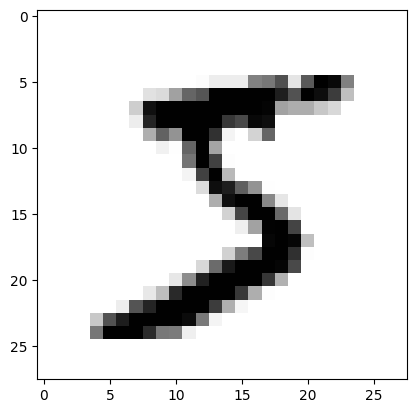

In [4]:
if len(x) < 50:
    plt.scatter(x, y_true)
elif x.shape[1] == 1:
    plt.plot(x, y_true)
else:
    with matplotlib.rc_context(rc={'image.cmap': 'gray_r'}):
        plt.imshow(x[0].reshape(28, 28))
print("x shape", x.shape, "y_true shape", y_true.shape)

# Train and Evaluate Model

In [5]:
y_true_onehot = keras.utils.to_categorical(y_true, num_classes=10)
print(y_true_onehot.shape)
y_true_onehot[:5]

(60000, 10)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [6]:
model = keras.Sequential([
    keras.layers.Input(shape=(784,)),
    keras.layers.Dense(800, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(
#     optimizer=keras.optimizers.SGD(learning_rate=0.01),
    optimizer=keras.optimizers.RMSprop(),
    loss='crossentropy',
    metrics=['accuracy']
)
history = model.fit(x, y_true_onehot, epochs=5, validation_split=.25)

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.8917 - loss: 0.3601 - val_accuracy: 0.9569 - val_loss: 0.1503
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.9711 - loss: 0.0950 - val_accuracy: 0.9695 - val_loss: 0.1031
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.9821 - loss: 0.0567 - val_accuracy: 0.9745 - val_loss: 0.0926
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.9873 - loss: 0.0420 - val_accuracy: 0.9749 - val_loss: 0.0977
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.9914 - loss: 0.0286 - val_accuracy: 0.9767 - val_loss: 0.0901


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<BarContainer object of 10 artists>

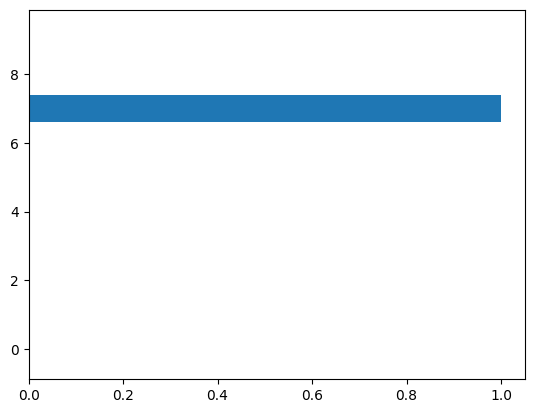

In [7]:
    probs = model.predict(test_images[0:1])
    plt.barh(np.arange(10), probs[0])

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Final Loss: 0.031, final weights: (800, 10), final bias: [-0.079 -0.121 -0.08   0.021 -0.021 -0.027 -0.125 -0.093  0.091 -0.047]


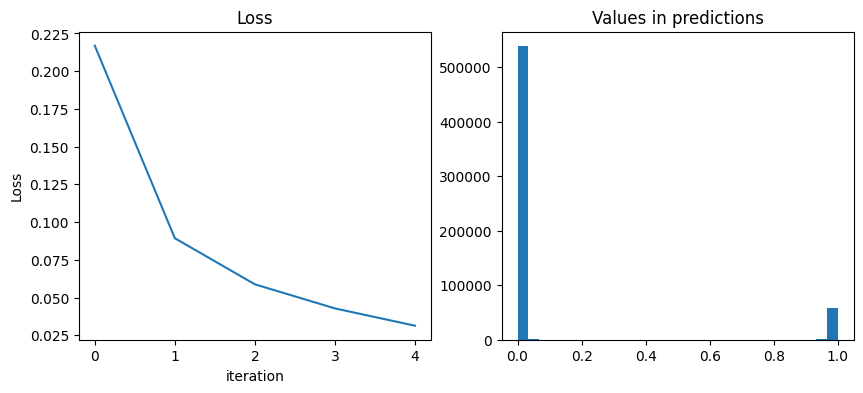

In [8]:
# Extract results from Keras
y_pred = model.predict(x)
losses = history.history['loss']
linear_layer = model.layers[-1]
# weights, bias = linear_layer.get_weights()

w1, b1 = model.layers[-2].get_weights()
w2, b2 = model.layers[-1].get_weights()
weights, bias = w2, b2

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(losses)
axs[0].set(title="Loss", xlabel="iteration", ylabel="Loss")
if x.shape[1] == 1:
    axs[1].scatter(x, y_true)
    axs[1].plot(x, y_pred, 'r');
    axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
else:
    axs[1].hist(y_pred.flatten(), bins=30)
    axs[1].set(title="Values in predictions")
print(f"Final Loss: {losses[-1]:.3f}, final weights: {weights.flatten() if len(weights.flatten()) < 25 else weights.shape}, final bias: {bias}")

In [9]:
# show_weight_images(linear_layer)

# Analysis

| Model Description                    | Prediction Equation | Weights shape | Biases shape | Loss Function | Validation Loss | Validation Accuracy |
|------------------------------------|----------------------|---------------|--------------|----------------|-----------------|----------------------|
| Linear regression (one number output) | `y = x @ W + b` | (784, 1) | (1,) | MSE | | |
| Linear regression (10 number output) | `y = x @ W + b` | (784, 10) | (10,) | MSE | 0.0449 | 0.8338 |
| Linear regression (softmax) | `y = x @ W + b` | (784, 10) | (10,) | MSE | 0.0118 | 0.9227 |
| Logistic Regression | `y = x @ W + b` | (784, 10) | (10,) | Cross Entropy | 0.2854 | 0.9257 |
| Evaluating by Hand | `y = x @ W + b` | (784, 10) | (10,) | Cross Entropy | 0.0121 | 0.9213 |
| Going Deeper | `y = max(0, x) @ W + b` | (8000, 10) | (10,) | Cross Entropy | 0.0954 | 0.9761 |

1. Linear

Describe how its training setup was different from the prior one. 

Used mnist dataset and less epochs and lower learning rate.

Describe why that difference should lead to an improvement in the results.

Should go faster  due to the reduced amount of epochs and not overfit.

Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model. 

It will return the number it thinks is right.

Describe how its accuracy differs from the previous one. 

Better because of mnist dataset previous training.

2. Linear

Describe how its training setup was different from the prior one. 

We used onehot.

Describe why that difference should lead to an improvement in the results. 

Splits it up into likeliness instead of one value.

Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model. 

The model floats -1 to .4, because we're doing likeliness but its not percentages yet.

Describe how its accuracy differs from the previous one. 

Its more accurate but hard to read because it shows likileness but we dont know how to check for the closest to the value we want.

3. Linear

Describe how its training setup was different from the prior one.

We added softmax activation to the dense layer. 

Describe why that difference should lead to an improvement in the results.

It makes it so that it is returning probabilities.

Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model. 

It is now a percentage floating-point between 0 and 1.

Describe how its accuracy differs from the previous one. 

Its more accurate and easier to read.

4. Logistic

Describe how its training setup was different from the prior one. 

Added crossentropy.

Describe why that difference should lead to an improvement in the results.

Measured the loss better.

Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model. 

Between 0 and 1 and adds up to 1, probability distribution.

Describe how its accuracy differs from the previous one. 

More accurate.

5. By Hand

Describe how its training setup was different from the prior one. 

Does the same thing but by hand.

Describe why that difference should lead to an improvement in the results. 

It is similiar to the previous model.

Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model.

Between 0 and 1 and adds up to 1.

Describe how its accuracy differs from the previous one.

It is about the same as the last one.

6. Deeper

Describe how its training setup was different from the prior one.

We add another layer to the model.

Describe why that difference should lead to an improvement in the results.

More testing is better.

Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model. 

It is between .06 and .13.

Describe how its accuracy differs from the previous one. 

It is really accurate because of the additional layer. 

1. How is the softmax operation useful in classification?

It allows us to get a probability distribution over the classifications.

2. Suppose an interviewer asks you “What’s the difference between linear regression and logistic regression?” Describe at least two differences you could mention.

One of the big differences is the loss function being different, for logistic it is crossentropy loss. The other difference is that a linear regression gives you a continuous values, while a logisitc regression gives you a probability distribution. 

3. The weight images helped us see that even though some of the models were getting good accuracy, they were doing so for the wrong reasons. Consider the weight images for the logistic regression model (Step 5). Why did the weights look vaguely like the digits? Why did the weights look not exactly like the digits?

The weight images looked vaguely like the images because it was giving different weights for different positions, you want to encourage spots where the pixel would look like the number and discourage pixels that wouldn't be in the number. They didn't look exactly like the image because there is some variation in writing the numbers.